In [1]:
import sys
sys.path.append('../src/')
from tqdm import tqdm
import pandas as pd
import wandb
import asyncio
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d


In [5]:

api = wandb.Api()
entity, project = "ajzero", "AlphaZero"
x_metric = "compute_budget"
tags = ['2024-02-16-14-42-43']
filters = {"tags": {"$in": tags}}
runs = api.runs(entity + "/" + project, filters=filters)
runs

<Runs ajzero/AlphaZero>

In [6]:
# crete a dataframe from runs and summary metrics

data = []
for run in tqdm(runs):
    summary = run.summary._json_dict
    config = run.config
    summary.update(config)
    data.append(summary)

df = pd.DataFrame(data)

df


100%|██████████| 36/36 [00:00<00:00, 71561.58it/s]


,Self_Play/EMA_Reward,_wandb,Training/Value_loss,Self_Play/Mean_Timesteps,Self_Play/Mean_Entropy,Training/Learning_Rate,Self_Play/Entropies,Training/Replay_Buffer_Size,Self_Play/Runtime_per_Timestep,Training/Regularization_loss,...,expansion_policy,n_steps_learning,selection_policy,value_loss_weight,max_episode_length,policy_loss_weight,sample_batch_ratio,regularization_weight,tree_evaluation_policy,replay_buffer_multiplier
0,-150.000000,{'runtime': 1652},227.653314,150.000,0.000000e+00,0.001,"{'_type': 'histogram', 'bins': [-0.5, -0.48437...",80,586.366667,216.927811,...,fromprior,1,PUCT,1,150,30,1,0.0001,mvto,10
1,-27.703563,{'runtime': 509},9.978056,15.000,2.540310e-10,0.001,"{'bins': [-0.49999999974596904, -0.48437499974...",80,6026.966667,206.670013,...,fromprior,1,PUCT,1,150,30,1,0.0001,minimal_variance_constraint,10
2,-51.793828,{'runtime': 592},167.842945,17.250,2.004083e-01,0.001,"{'_type': 'histogram', 'bins': [0.185181349515...",80,5976.507246,253.612686,...,fromprior,1,PUCT,1,150,30,1,0.0001,default,10
3,-150.000000,{'runtime': 510},865.775610,150.000,0.000000e+00,0.001,"{'values': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",80,37.320000,256.000641,...,fromprior,1,PUCT,1,150,30,1,0.0001,mvto,10
4,-21.949463,{'runtime': 3291},5.711294,18.750,1.658624e-01,0.001,"{'values': [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",80,422.353333,207.109756,...,fromprior,1,PUCT,1,150,30,1,0.0001,minimal_variance_constraint,10
5,-32.061474,{'runtime': 276},33.535610,18.375,2.523540e-01,0.001,"{'_type': 'histogram', 'bins': [0.213095446427...",80,1394.700680,220.476440,...,fromprior,1,PUCT,1,150,30,1,0.0001,default,10
6,-150.000000,{'runtime': 249},533.348837,150.000,0.000000e+00,0.001,"{'_type': 'histogram', 'bins': [-0.5, -0.48437...",80,789.998333,255.362732,...,fromprior,1,PUCT,1,150,30,1,0.0001,mvto,10
7,-38.322834,{'runtime': 191},122.611740,15.250,3.840190e-02,0.001,"{'bins': [0.03343520959218343, 0.0337456275708...",80,4339.270492,258.991516,...,fromprior,1,PUCT,1,150,30,1,0.0001,minimal_variance_constraint,10
8,-80.304985,{'runtime': 254},681.876740,18.625,3.965228e-01,0.001,"{'bins': [0.38211086818150114, 0.3825200257055...",80,3678.872483,309.625977,...,fromprior,1,PUCT,1,150,30,1,0.0001,default,10
9,-149.609972,{'runtime': 185},114.028210,150.000,0.000000e+00,0.001,"{'bins': [-0.5, -0.484375, -0.46875, -0.453125...",80,806.216667,276.495941,...,fromprior,1,PUCT,1,150,30,1,0.0001,mvto,10


In [7]:
df.columns

Index(['Self_Play/EMA_Reward', '_wandb', 'Training/Value_loss',
       'Self_Play/Mean_Timesteps', 'Self_Play/Mean_Entropy',
       'Training/Learning_Rate', 'Self_Play/Entropies',
       'Training/Replay_Buffer_Size', 'Self_Play/Runtime_per_Timestep',
       'Training/Regularization_loss', 'Self_Play/Timesteps_STD',
       'Self_Play/Min_Timesteps', 'Self_Play/Total_Average_Reward',
       'Training/Policy_loss', 'Self_Play/Min_Reward',
       'Self_Play/Total_Runtime', 'Training/Value_and_Policy_loss',
       'Self_Play/Mean_Reward', 'Self_Play/Reward_STD', '_runtime',
       'Self_Play/Total_Timesteps', 'Self_Play/Max_Reward', '_step',
       'Self_Play/Timesteps', 'Self_Play/Rewards', '_timestamp',
       'Training/Value_Simularities', 'Self_Play/Cumulative_Reward', 'env_id',
       'layers', 'puct_c', 'lr_gamma', 'eval_param', 'hidden_dim',
       'iterations', 'model_type', 'norm_layer', 'activation_fn',
       'learning_rate', 'compute_budget', 'discount_factor', 'training_epoch

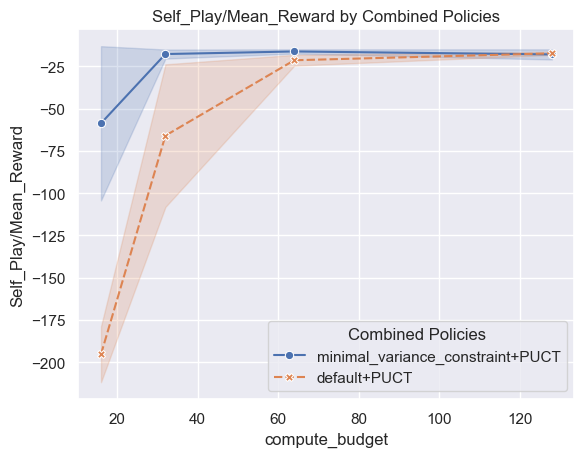

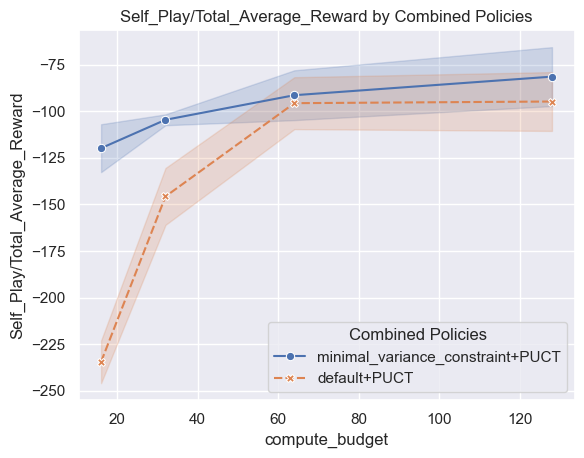

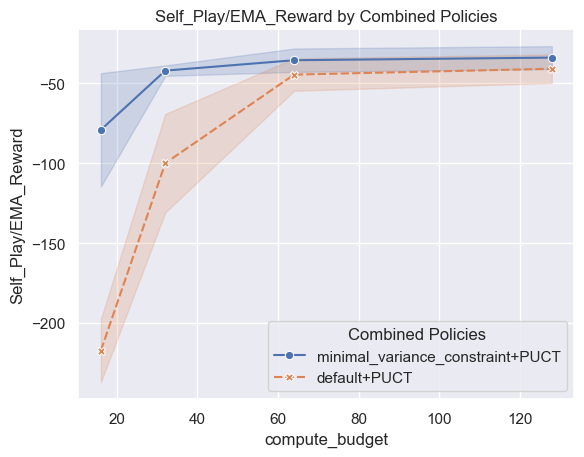

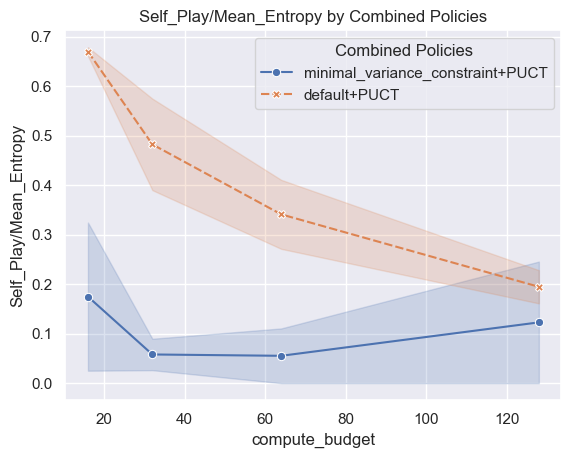

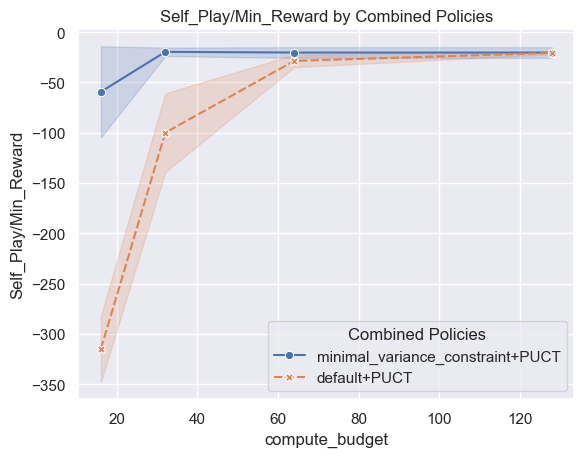

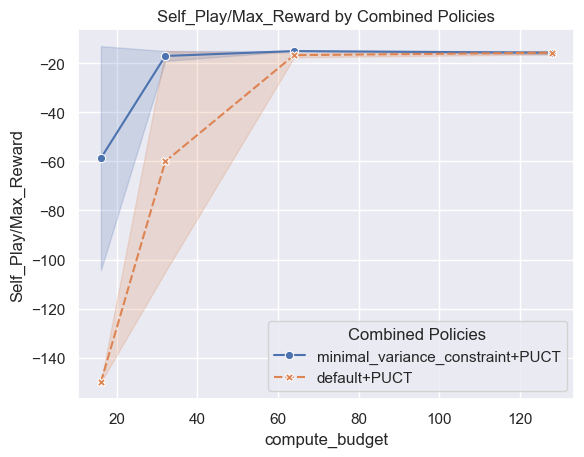

In [11]:


df['policy_combination'] = df['tree_evaluation_policy'] + "+" + df['selection_policy']

metrics = ['Self_Play/Mean_Reward', "Self_Play/Total_Average_Reward", "Self_Play/EMA_Reward", 'Self_Play/Mean_Entropy', 'Self_Play/Min_Reward',
           'Self_Play/Max_Reward',
           #'max_Self_Play/Mean_Reward', 'max_Self_Play/Mean_Reward_step'
           ]

for metric in metrics:
    sns.set_theme(style="darkgrid")

    # Create a line plot with confidence intervals
    sns.lineplot(data=df[df['tree_evaluation_policy'] != 'mvto'],
                 x=x_metric, y=metric,
                hue="policy_combination", style="policy_combination",
                markers=True, errorbar="se", estimator="mean")

    # Customize the plot with titles and labels
    plt.title(f'{metric} by Combined Policies')
    plt.xlabel(x_metric)  # Replace with actual x-axis label
    plt.ylabel(metric)
    plt.legend(title='Combined Policies')
    # plt.gca().set_xscale('log', base=10)

    # Show the plot
    plt.show()
